# Naive Bayes : Ham/Spam SMS Prediction

## Import Dependencies

In [77]:
import nltk
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import plot_confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.metrics import plot_confusion_matrix
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score


In [16]:
import pandas
df_sms = pd.read_csv('spam.csv',encoding='latin-1')
df_sms.head()

,v1,v2,Unnamed: 2,Unnamed: 3,Unnamed: 4
0,ham,"Go until jurong point, crazy.. Available only ...",NaN,NaN,NaN
1,ham,Ok lar... Joking wif u oni...,NaN,NaN,NaN
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,NaN,NaN,NaN
3,ham,U dun say so early hor... U c already then say...,NaN,NaN,NaN
4,ham,"Nah I don't think he goes to usf, he lives aro...",NaN,NaN,NaN


## Data Preprocessing

In [17]:
## Dropping the unwanted columns Unnamed:2, Unnamed: 3 and Unnamed:4
df_sms = df_sms.drop(["Unnamed: 2", "Unnamed: 3", "Unnamed: 4"], axis=1)

In [18]:
## Rename the Columns for better understanding
df_sms = df_sms.rename(columns={"v1":"label", "v2":"sms"})

df_sms.head()


,label,sms
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


In [20]:
## Add new columns reprsenting the lenght of SMS
df_sms['length'] = df_sms['sms'].apply(len)

df_sms.head()

,label,sms,length
0,ham,"Go until jurong point, crazy.. Available only ...",111
1,ham,Ok lar... Joking wif u oni...,29
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,155
3,ham,U dun say so early hor... U c already then say...,49
4,ham,"Nah I don't think he goes to usf, he lives aro...",61


In [23]:
## Check for null values
df_sms.isnull().sum()

label     0
sms       0
length    0
dtype: int64

## Manual Encoding

In [24]:
df_sms.loc[:,'label'] = df_sms.label.map({'ham':0, 'spam':1})
df_sms.head()

(5572, 3)


,label,sms,length
0,0,"Go until jurong point, crazy.. Available only ...",111
1,0,Ok lar... Joking wif u oni...,29
2,1,Free entry in 2 a wkly comp to win FA Cup fina...,155
3,0,U dun say so early hor... U c already then say...,49
4,0,"Nah I don't think he goes to usf, he lives aro...",61


## Exploratory Data Analysis

In [25]:
#Number of observations in each label spam and ham
df_sms.label.value_counts()

0    4825
1     747
Name: label, dtype: int64

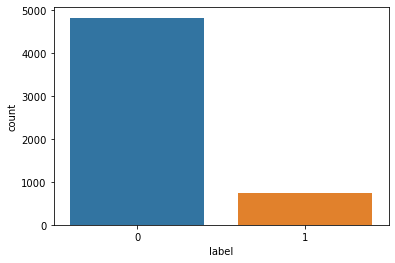

In [26]:
sns.countplot(df_sms["label"])

#### Frequecnies
- Spam : 4825
- Ham  :  747

Text(0.5, 0, 'Lenght of SMS')

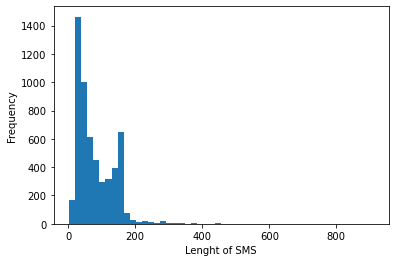

In [28]:
# Check distrubution of lenght
df_sms['length'].plot(bins=50, kind='hist')
plt.xlabel("Lenght of SMS")

- Most of the SMS are have lenght below 100 and there are only few SMS having lenght greater than 200

In [30]:
## check lenght of SMS for HAM and SPAM

array([<matplotlib.axes._subplots.AxesSubplot object at 0x0000019F4C1042E0>,
      dtype=object)

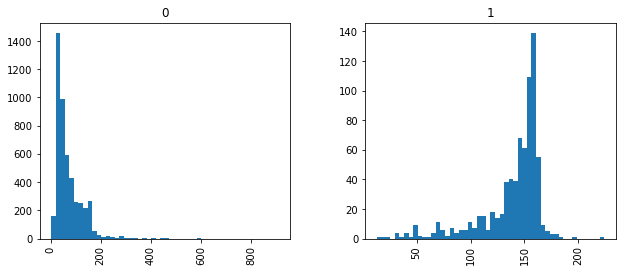

In [34]:
df_sms.hist(column='length', by='label', bins=50,figsize=(10,4))

- Major HAM SMS are shorter in lenght and having lenghts are less than 100
- Major SPAM SMS are lenghty and having lenghts are more than 125 

## Data preprocessing with CountVectorizer()

#### CountVectorizer()

CountVectorizer() will clean the data converting all text to lower case, removing all punctuation marks and stops words.
Below are the 3 by default steps: 

- 1. **lowercase = True**: 
    The lowercase parameter has a default value of True which converts all of our text to its lower case form.
- ....
    
- 2. **token_pattern = (?u)\b\w\w+\b**: 
    The token_pattern parameter has a default regular expression value of (?u)\b\w\w+\b which ignores all punctuation
    marks and treats them as delimiters, while accepting alphanumeric strings of length greater than or equal to 2, 
    as individual tokens or words.
- .....
    
- 3. **stop_words**:   The stop_words parameter, if set to english will remove all words from our document set that match a list of English stop words which is defined in scikit-learn.
    

In [54]:
## let just see how CountVectorizer() works by example and taking 4 sentence in it

count_vector = CountVectorizer()

documents = ['Hello, how are you!', 'Win money, win from home.', 'Call me now.', 'Hello, Call hello you tomorrow?']

count_vector.fit(documents)
print("Feature Name:",count_vector.get_feature_names(),end="\n\n")

doc_array = count_vector.transform(documents).toarray()
print("Feature Frequencies:\n",doc_array)

print("\n\nFrequecy Matrix")
frequency_matrix = pd.DataFrame(doc_array, columns = count_vector.get_feature_names())
frequency_matrix

Feature Name: ['are', 'call', 'from', 'hello', 'home', 'how', 'me', 'money', 'now', 'tomorrow', 'win', 'you']

Feature Frequencies:
 [[1 0 0 1 0 1 0 0 0 0 0 1]
 [0 0 1 0 1 0 0 1 0 0 2 0]
 [0 1 0 0 0 0 1 0 1 0 0 0]
 [0 1 0 2 0 0 0 0 0 1 0 1]]


Frequecy Matrix


,are,call,from,hello,home,how,me,money,now,tomorrow,win,you
0,1,0,0,1,0,1,0,0,0,0,0,1
1,0,0,1,0,1,0,0,1,0,0,2,0
2,0,1,0,0,0,0,1,0,1,0,0,0
3,0,1,0,2,0,0,0,0,0,1,0,1


### Split the Data To Training And Testing Set

In [53]:

X_train, X_test, y_train, y_test = train_test_split(df_sms['sms'],df_sms['label'],test_size=0.20,random_state=1)

In [63]:
# Instantiate the CountVectorizer method
count_vector = CountVectorizer()

# Fit the training data and then return the matrix
training_data = count_vector.fit_transform(X_train)

# Transform testing data and return the matrix. 
testing_data = count_vector.transform(X_test)

### Naive Bayes Machine Learning Algorithm

- Gaussian: It is used in classification and it assumes that features follow a normal distribution.

- Multinomial: It is used for discrete counts. For example, let’s say,  we have a text classification problem. Here we can consider Bernoulli trials which is one step further and instead of “word occurring in the document”, we have “count how often word occurs in the document”, you can think of it as “number of times outcome number x_i is observed over the n trials”.

- Bernoulli: The binomial model is useful if your feature vectors are binary (i.e. zeros and ones). One application would be text classification with ‘bag of words’ model where the 1s & 0s are “word occurs in the document” and “word does not occur in the document” respectively.

In [66]:
naive_bayes = MultinomialNB()
naive_bayes.fit(training_data,y_train)

MultinomialNB()

In [67]:
predictions = naive_bayes.predict(testing_data)

In [72]:
# Compare result
result=pd.DataFrame({"Actual":y_test,"Predicted":predictions})
result

,Actual,Predicted
1078,0,0
4028,0,0
958,0,0
4642,0,0
4674,1,0
...,...,...
324,0,0
1163,0,0
86,0,0
4214,0,0


### Model Evaluation

In [76]:
print('Accuracy score: {}'.format(accuracy_score(y_test, predictions)))
print('Precision score: {}'.format(precision_score(y_test, predictions)))
print('Recall score: {}'.format(recall_score(y_test, predictions)))
print('F1 score: {}'.format(f1_score(y_test, predictions)))

Accuracy score: 0.9847533632286996
Precision score: 0.9420289855072463
Recall score: 0.935251798561151
F1 score: 0.9386281588447652


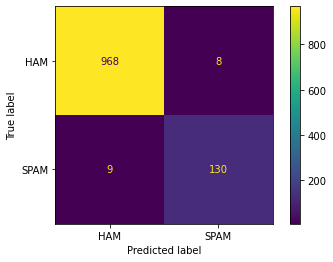

In [80]:
plot_confusion_matrix(naive_bayes,testing_data,y_test,values_format="d",display_labels=["HAM","SPAM"])

- One of the major advantages that Naive Bayes has over other classification algorithms is its ability to handle an extremely large number of features. In our case, each word is treated as a feature and there are thousands of different words. Also, it performs well even with the presence of irrelevant features and is relatively unaffected by them.

- The other major advantage it has is its relative simplicity. Naive Bayes' works well right out of the box and tuning it's parameters is rarely ever necessary, except usually in cases where the distribution of the data is known.

- It rarely ever overfits the data.

- Another important advantage is that its model training and prediction times are very fast for the amount of data it can handle.